In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rasterio

# Datos necesarios
* Población a nivel de AGEBs 2020 **Listo**
* Red carretera **Listo**
* Ubicación geográfica de fuentes puntuales de emisión
* Continuo de Elevaciones Mexicano **Listo**
* Emisiones de Partículas PM2.5 de fuentes puntuales, de área y móviles a nivel 
de celda

# Reclasificación AGEBS con población

In [2]:
agebs_colima = gpd.read_file("data/06_colima/06a.shp")
agebs_colima = agebs_colima[["CVEGEO", "geometry"]]

In [3]:
pop2020 = pd.read_excel("data/IM/IMU_2020.xls", sheet_name="IMU_2020")
pop_colima = pop2020[pop2020["ENT"] == 6]
pop_colima = pop_colima[['CVE_AGEB', 'ENT', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC','AGEB', 'POB_TOTAL', 'GM_2020']]

In [4]:
agebs_pop = agebs_colima.merge(pop_colima, left_on="CVEGEO", right_on="CVE_AGEB")

# reclassify column POB_TOTAL in 10 classes, from 1 to 10 with beautiful labels
agebs_pop["pop"] = pd.qcut(agebs_pop["POB_TOTAL"], 10, labels=range(1,11))

# show range of POB_TOTAL values for each class
ranges = agebs_pop["POB_TOTAL"].groupby(agebs_pop["pop"]).describe()

ranges.reset_index(inplace=True)

ranges["range"] = ranges["min"].astype(str) + " - " + ranges["max"].astype(str)
ranges = ranges[["pop", "range", "min"]]

In [5]:
agebs_pop = gpd.GeoDataFrame(agebs_pop.merge(ranges, on="pop"))
agebs_pop['pop'] = agebs_pop['pop'].astype(int)
agebs_pop.sort_values(by="pop", inplace=True)
agebs_pop.head()

,CVEGEO,geometry,CVE_AGEB,ENT,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,POB_TOTAL,GM_2020,pop,range,min
249,0600100010344,"POLYGON ((2292711.812 773728.056, 2292719.285 ...",0600100010344,6,Colima,1,Armería,1,Ciudad de Armería,0344,109,Alto,1,56.0 - 234.0,56.0
277,0600700010973,"POLYGON ((2255124.757 793230.483, 2255011.407 ...",0600700010973,6,Colima,7,Manzanillo,1,Manzanillo,0973,121,Alto,1,56.0 - 234.0,56.0
278,060070001169A,"POLYGON ((2257946.420 791991.918, 2257928.786 ...",060070001169A,6,Colima,7,Manzanillo,1,Manzanillo,169A,91,Muy bajo,1,56.0 - 234.0,56.0
279,0600700010831,"POLYGON ((2252420.362 795395.656, 2252442.001 ...",0600700010831,6,Colima,7,Manzanillo,1,Manzanillo,0831,149,Alto,1,56.0 - 234.0,56.0
280,060090001086A,"POLYGON ((2301600.485 773399.035, 2301629.528 ...",060090001086A,6,Colima,9,Tecomán,1,Tecomán,086A,217,Bajo,1,56.0 - 234.0,56.0


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


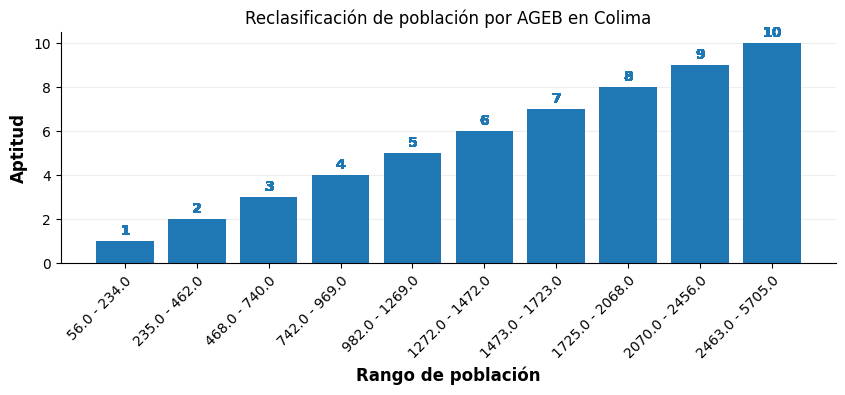

In [6]:
fig, ax = plt.subplots( figsize=(10,3))
plt.rc('font', family='Open Sans')

bars = ax.bar(x=agebs_pop["range"], height=agebs_pop["pop"])

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# rotate xtick labels 45 degrees
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Reclasificación de población por AGEB en Colima")
ax.set_xlabel("Rango de población", fontsize=12, fontweight="bold")
ax.set_ylabel("Aptitud", fontsize=12, fontweight="bold")
sns.despine()
plt.show()

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

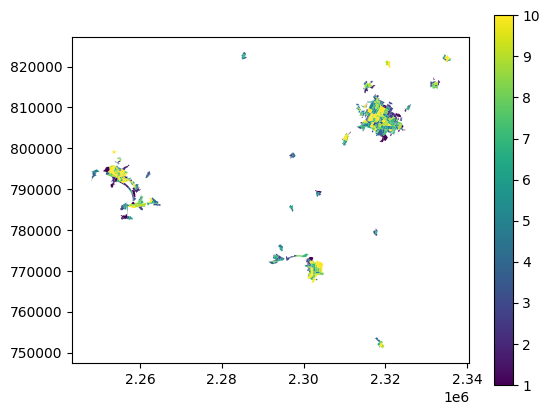

In [7]:
agebs_pop.plot(column="pop", legend=True)

## Ejes de vialidades

In [8]:
vialidades = gpd.read_file("data/06_colima/06e.shp")
vialidades.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVEVIAL,CVESEG,NOMVIAL,TIPOVIAL,SENTIDO,TIPOSEN,AMBITO,geometry
0,060010001,06,001,0001,00198,00005,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (2292640.374 771982.998, 2292646.65..."
1,060010001,06,001,0001,00201,00003,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (2292758.449 771930.866, 2292764.59..."
2,060010001,06,001,0001,00048,00002,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (2292698.284 773565.590, 2292669.14..."
3,060010001,06,001,0001,00371,00001,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (2292767.501 773601.071, 2292761.30..."
4,060010001,06,001,0001,00370,00001,Ninguno,Calle,Dos sentidos,2,Urbana,"LINESTRING (2292092.383 772393.627, 2292094.15..."


## Continuo de elevación

In [12]:
# open tif file 
CEM = rasterio.open("data/CEM_COLIMA/Colima_r15m.tif")

CEM

<open DatasetReader name='data/CEM_COLIMA/Colima_r15m.tif' mode='r'>

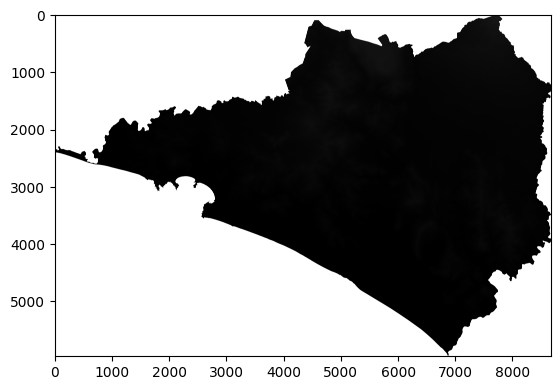

In [13]:
plt.imshow(CEM.read(1), cmap='gray')